## Домашнее здание №3 / New Product Forecasting

### Фамилия Имя / Группа

----
План выполнения домашнего задания:

1. Подготовка данных
2. Предсказание без категориальных признаков
3. Предсказание с категориальными признаками
4.  Другие модели и генерация дополнительных признаков
5. Отправка результатов в контест на Kaggle

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn import tree
from copy import deepcopy
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.dummy import DummyRegressor
from scipy.optimize import minimize_scalar
%matplotlib inline

## Подготовка данных (1 балл)
 * Изучить признаки
 * Выделить категориальные признаки, которые можно использовать для обучения
 * Выделить датасет только с числовыми признаками
 * Выделить полезные числовые признаки

In [4]:
# data = pd.read_csv('blogData_train.csv', header=None)
data = pd.read_csv('./data/train.csv', sep=';', index_col='ID')
data.shape

(40000, 33)

In [3]:
# Посмотрим на данные
data.head()

,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,...,STORE_FORMAT,STORE_OPEN_DTTM,STORE_PRICE_TYPE,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,,,,,,,
0,0.10536,1835543262,ark,5179.7500,NaN,5.5,big,720.0,1682,NaN,...,новый формат,19MAY15:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,B,0.67,0.75,0.25,0.0,3.06
1,0.00010,1972241965,samsung,22015.3300,NaN,5.2,big,1920.0,34706,NaN,...,новый формат,20JAN16:00:00:00,розничная цена (северо-запад-днс1),северо-запад,C,0.48,0.00,1.00,0.0,2.51
2,0.00010,2027986985,samsung,15592.5900,NaN,5.0,big,1280.0,2753,NaN,...,новый формат,27APR16:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.64,1.00,0.00,0.0,2.72
3,0.00010,28432,alcatel,540.9533,29.0,1.8,small,128.0,1593,7.533,...,стандарт,21OCT09:00:00:00,розничная цена (северо-запад-боровичи),северо-запад,B,0.65,0.50,0.25,0.0,2.04
4,0.00010,28547,мтс,444.7300,30.0,4.0,medium,480.0,80644,16.830,...,стандарт,20MAY09:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.83,0.75,0.25,0.0,2.37


### Категориальные признаки
 * Какие категориальные признаки следует использовать в первую очередь? 
 * Есть ли категориальные признаки, которые в принципе не понятно, как использовать?

In [5]:
# Определяем категориальные признаки
# По понятным причинам 'LOCATION_ID', 'MODEL_ID' считаются числовыми признаками - их добавляем руками отдельно
Categorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])]
Categorical_columns

Index(['MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_NAME', 'MODEL_OS',
       'MODEL_RES_TYPE', 'MODEL_TYPE', 'STORE_BRAND_ABC',
       'STORE_BUILDING_TYPE', 'STORE_CITY', 'STORE_CLUSTER', 'STORE_DIAG_ABC',
       'STORE_FORMAT', 'STORE_OPEN_DTTM', 'STORE_PRICE_TYPE', 'STORE_REGION',
       'STORE_RES_ABC'],
      dtype='object')

In [5]:
# Количество уникальных значений в категориальных признаках
dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Categorical_columns]}, index = Categorical_columns)

print('Количество уникальных категориальных значений: '+ str(dist_val.sum().values))
print('Удаляем признаки с номерами: \n'+ str(dist_val.ix[dist_val['NoUniqueValues']>0].sort_values(by='NoUniqueValues', ascending=False)))

Количество уникальных категориальных значений: [845]
Удаляем признаки с номерами: 
                     NoUniqueValues
MODEL_NAME                      447
STORE_OPEN_DTTM                 246
STORE_CITY                       36
MODEL_BRAND                      33
STORE_CLUSTER                    23
STORE_PRICE_TYPE                 20
STORE_FORMAT                     10
MODEL_OS                          5
STORE_REGION                      5
MODEL_DIAG_TYPE                   3
MODEL_RES_TYPE                    3
STORE_BRAND_ABC                   3
STORE_BUILDING_TYPE               3
STORE_DIAG_ABC                    3
STORE_RES_ABC                     3
MODEL_TYPE                        2


In [12]:
# Запоминаем те категориальные признаки, с которыми не будем далее работать (используется далее)
Categorical_columns_use = Categorical_columns[:]
Categorical_columns_use

Index(['MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_NAME', 'MODEL_OS',
       'MODEL_RES_TYPE', 'MODEL_TYPE', 'STORE_BRAND_ABC',
       'STORE_BUILDING_TYPE', 'STORE_CITY', 'STORE_CLUSTER', 'STORE_DIAG_ABC',
       'STORE_FORMAT', 'STORE_OPEN_DTTM', 'STORE_PRICE_TYPE', 'STORE_REGION',
       'STORE_RES_ABC'],
      dtype='object')

### Числовые признаки
* Какие числовые признаки следует использовать в первую очередь? 
* Есть ли числовые признаки, которые в принципе не понятно, как использовать?
* Как заполнять NaN?

In [6]:
# Выделяем числовой датасет: В данном случае удаляем все + MODEL_ID и LOCATION_ID
num_data = data.drop(Categorical_columns | data.columns[[1,8]], axis = 1)
num_data.columns

Index(['DEMAND', 'MODEL_COST_AVG', 'MODEL_COUNT_SALES_DAYS', 'MODEL_DIAG',
       'MODEL_HEIGHT', 'MODEL_MEAN_SALES', 'MODEL_WIDTH', 'STORE_ASSORTMENT',
       'STORE_BRAND_SPECTR', 'STORE_DIAG_SPECTR', 'STORE_RES_SPECTR',
       'STORE_TYPE_A', 'STORE_TYPE_B', 'STORE_TYPE_C', 'STORE_TYPE_SPECTR'],
      dtype='object')

In [18]:
# Количество NaN в числовых признаках
print('Количество NaN:')
nan_val = num_data.isnull().sum().T
nan_val
# print('Удаляем признаки с номерами: \n'+ str(nan_val.sort_values(by='NoUniqueValues', ascending=False)))

Количество NaN:


DEMAND                        0
MODEL_COST_AVG                0
MODEL_COUNT_SALES_DAYS    18917
MODEL_DIAG                  212
MODEL_HEIGHT                212
MODEL_MEAN_SALES          18917
MODEL_WIDTH                 212
STORE_ASSORTMENT            235
STORE_BRAND_SPECTR          235
STORE_DIAG_SPECTR           442
STORE_RES_SPECTR            446
STORE_TYPE_A                  0
STORE_TYPE_B                  0
STORE_TYPE_C                  0
STORE_TYPE_SPECTR             0
dtype: int64

##### Преобразовываем числовые признаки (удаляем/добавляем/заменяем nan)

In [ ]:
# Здесь добавьте код по преобразованию числовых признаков

# пример
num_data[???][num_data[???]<числовой порог]=значение

In [19]:
# Здесь добавьте код по заполнению NaN
num_data = num_data[:].fillna(0)


In [ ]:
# Здесь добавьте код по удалению числовых признаков
num_data.drop([список фич], axis = 1, inplace=True)
num_data.columns

In [21]:
num_data.head()

,DEMAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_HEIGHT,MODEL_MEAN_SALES,MODEL_WIDTH,STORE_ASSORTMENT,STORE_BRAND_SPECTR,STORE_DIAG_SPECTR,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,
0,0.10536,5179.7500,0.0,5.5,720.0,0.000,1280.0,136.0,0.76,0.78,0.67,0.75,0.25,0.0,3.06
1,0.00010,22015.3300,0.0,5.2,1920.0,0.000,1080.0,70.0,0.73,0.65,0.48,0.00,1.00,0.0,2.51
2,0.00010,15592.5900,0.0,5.0,1280.0,0.000,1280.0,106.0,0.89,0.67,0.64,1.00,0.00,0.0,2.72
3,0.00010,540.9533,29.0,1.8,128.0,7.533,160.0,132.0,0.67,0.60,0.65,0.50,0.25,0.0,2.04
4,0.00010,444.7300,30.0,4.0,480.0,16.830,800.0,95.0,1.00,0.71,0.83,0.75,0.25,0.0,2.37


## Предсказание без категориальных признаков (1 балл)
### Вспомогательные функции

In [7]:
def smape_loss_func(x, y):
    SymAPE = [ 2*np.abs(x-y)/(np.abs(x)+np.abs(y))] 
    return np.mean(SymAPE)

def get_numerated_data(df, categorical_columns):
    simple_df = deepcopy(df)
    for column in categorical_columns:
        simple_df[column] = pd.Categorical.from_array(simple_df[column]).labels
    
    return simple_df

def get_binarized_data(df, categorical_columns):
    binary_df = deepcopy(df)
    for column in categorical_columns:
        binary_df = pd.concat([binary_df, pd.get_dummies(binary_df[column], prefix=column, prefix_sep=': ')], axis=1)
        del binary_df[column]
    
    return binary_df

def split_to_numpy(df, y_column_name):
    #print df
    #print y_column_name
    data_x = df.drop(y_column_name, axis=1).values.astype(np.float32)
    data_y = df[y_column_name].values.astype(np.float32)
    column_names = df.drop(y_column_name, axis=1).columns
    
    return data_x, data_y, column_names

def split_train_test(df, test_size=0.5, random_state=42, y_column_name='y'):
    X = np.asarray(df.drop(y_column_name, axis=1))
    y = np.asarray(df[y_column_name]).ravel()
    trainX, testX, trainY, testY = cross_validation.train_test_split(X, y, test_size=test_size, random_state=42)
    return trainX, testX, trainY, testY

### Необходимые функции

In [8]:
def show_plot(n_est, res, title="", ylabel="acc"):
    fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][1] for x in n_est], 'ro')
#     ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
#     plt.xlabel("n_estimators")
#     plt.ylabel(ylabel)
#     plt.title("Test result")
#     plt.show()
    
#     fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][0] for x in n_est], 'bo')
    ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
    plt.xlabel("n_estimators")
    plt.ylabel("acc")
    plt.title(title)
    plt.show()

def get_results_dummy_reg(acc=smape_loss_func, verbose=True, strg ='mean', const=None):
    results = dict()
    reg = DummyRegressor(strategy=strg, constant=const)
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    results[1] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    if verbose:
        print("Accuracy: " + str(results[1][1]))
    return results

def get_results_baggind_rsm(n_est, max_samples, max_features, acc=smape_loss_func, verbose=True):
    results = dict()
    for i in n_est:
        reg = BaggingRegressor(n_estimators=i,
                          max_samples=max_samples, max_features=max_features, random_state=1234, n_jobs=-1, verbose=0)
        reg.fit(trainX, trainY)
#         results[i] = (mse(reg.predict(trainX), trainY), mse(reg.predict(testX), testY))
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_rf(n_est, oob=False, verbose=True, acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=1234, verbose=0,
                                    oob_score=oob, max_features='sqrt')
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if oob:
            results[i] = (reg.oob_score_, acc(predict, testY))
        else:
            results[i] = (acc(trainY, reg.predict(trainX)), acc(testY,predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_erte(n_est, verbose=True,acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = ExtraTreesRegressor(n_estimators=i, n_jobs=-1, random_state=12, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY,reg.predict(trainX)), acc(predict, testY))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_gbdt(n_est, verbose=True, init=None, acc=smape_loss_func, min_max_filter=True, max_val=1, min_val=0.001):
    results = dict()
    for i in n_est:
        if init is not None:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0, init=init)
        else:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if min_max_filter:
            predict = np.minimum(np.maximum(predict, min_val),max_val)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))    
    return results

def get_optimal(results):
    results = sorted(results, key=lambda x: x[1])

### Делим выборку на обучение и контроль

In [24]:
trainX, testX, trainY, testY = split_train_test(df = num_data, test_size=0.1,  y_column_name='DEMAND')

### DummyRegressor
* Самый простой классификатор на числовых признаках используется как база для сравнения

In [28]:
%time results = get_results_dummy_reg()
%time results = get_results_dummy_reg(strg='constant', const=0.001)

Accuracy: 1.24306344718
CPU times: user 2.59 ms, sys: 2.56 ms, total: 5.15 ms
Wall time: 7.13 ms
Accuracy: 1.81014628129
CPU times: user 1.78 ms, sys: 251 µs, total: 2.03 ms
Wall time: 1.84 ms


### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

** Каким стоит брать размер bootstrap выборки и RSM выборки ** 
Например: 
**Bagging:** 0.5 от размера тестовой выборки.

**RSM:** 0.5 от размера тестовой выборки.

Count of estimators: 10, accuracy: 1.21774274385
Count of estimators: 20, accuracy: 1.21305809723
Count of estimators: 30, accuracy: 1.21379748214
Count of estimators: 40, accuracy: 1.215807349
Count of estimators: 50, accuracy: 1.21933236944
Count of estimators: 60, accuracy: 1.22203564621
Count of estimators: 70, accuracy: 1.22560923922
Count of estimators: 80, accuracy: 1.22419567795
Count of estimators: 90, accuracy: 1.22222779993
Count of estimators: 100, accuracy: 1.22245101935
Count of estimators: 110, accuracy: 1.22268253357
Count of estimators: 120, accuracy: 1.22276289102
Count of estimators: 130, accuracy: 1.22206953169
Count of estimators: 140, accuracy: 1.22173368298
CPU times: user 9.89 s, sys: 11 s, total: 20.9 s
Wall time: 56.1 s


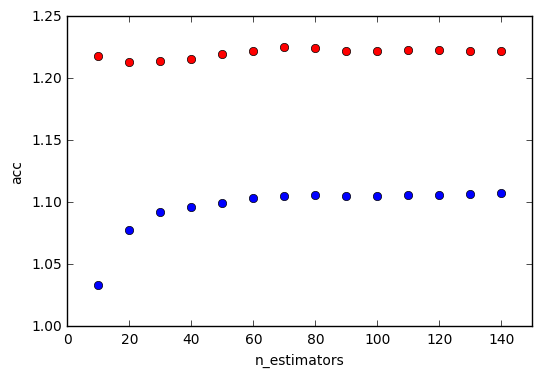

In [29]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.5, 0.5, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.17131553871
Count of estimators: 20, accuracy: 1.2004546997
Count of estimators: 30, accuracy: 1.213393472
Count of estimators: 40, accuracy: 1.21507762233
Count of estimators: 50, accuracy: 1.21735404006
Count of estimators: 60, accuracy: 1.22076706273
Count of estimators: 70, accuracy: 1.22179058141
Count of estimators: 80, accuracy: 1.22103911739
Count of estimators: 90, accuracy: 1.22188767884
Count of estimators: 100, accuracy: 1.22136453923
Count of estimators: 110, accuracy: 1.22200476955
Count of estimators: 120, accuracy: 1.22354990285
Count of estimators: 130, accuracy: 1.2224354836
Count of estimators: 140, accuracy: 1.22302627025
CPU times: user 1min 48s, sys: 4.14 s, total: 1min 52s
Wall time: 24.8 s


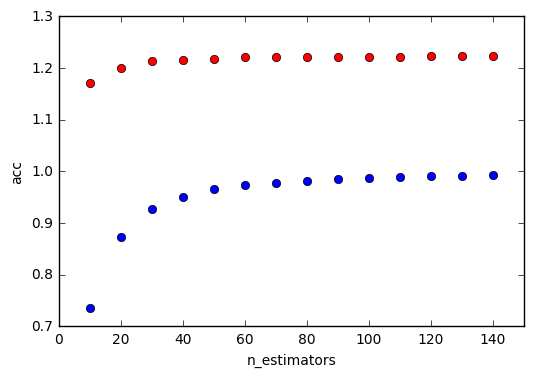

In [30]:
n_est = range(10, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.12091976304
Count of estimators: 20, accuracy: 1.17790010277
Count of estimators: 30, accuracy: 1.19418458165
Count of estimators: 40, accuracy: 1.20623607293
Count of estimators: 50, accuracy: 1.21183587383
Count of estimators: 60, accuracy: 1.21498340796
Count of estimators: 70, accuracy: 1.21925564396
Count of estimators: 80, accuracy: 1.22061792864
Count of estimators: 90, accuracy: 1.2215958102
Count of estimators: 100, accuracy: 1.22307515192
Count of estimators: 110, accuracy: 1.22279120412
Count of estimators: 120, accuracy: 1.22325376995
Count of estimators: 130, accuracy: 1.22321926016
Count of estimators: 140, accuracy: 1.22423500934
CPU times: user 2min 58s, sys: 6.6 s, total: 3min 5s
Wall time: 38.7 s


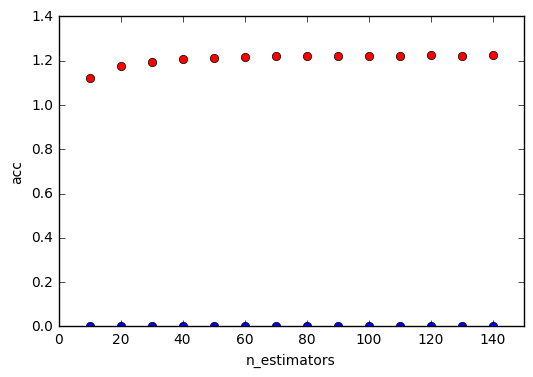

In [33]:
n_est = range(10, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

## Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.2304547461
Count of estimators: 20, accuracy: 1.22779720184
Count of estimators: 30, accuracy: 1.22706365229
Count of estimators: 40, accuracy: 1.22345469839
Count of estimators: 50, accuracy: 1.22399131853
Count of estimators: 60, accuracy: 1.22460004627
Count of estimators: 70, accuracy: 1.22345641658
Count of estimators: 80, accuracy: 1.22109049627
Count of estimators: 90, accuracy: 1.22276717505
Count of estimators: 100, accuracy: 1.22402149904
Count of estimators: 110, accuracy: 1.22424030573
Count of estimators: 120, accuracy: 1.22514145741
Count of estimators: 130, accuracy: 1.22448663262
Count of estimators: 140, accuracy: 1.22513444298
CPU times: user 27.1 s, sys: 240 ms, total: 27.4 s
Wall time: 28.3 s


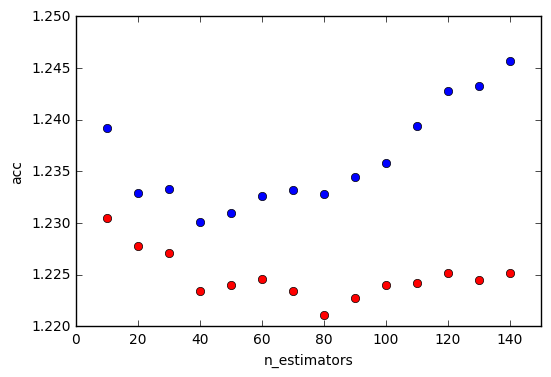

In [34]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод
Переобучаются ExtraDT, остальные методы показывают результаты на одном уровне (в пределах погрешности).

Для RF и Baggin+RSM оптимальные значения кол-ва близко к 20.

Для GBDT оптимальное количество алгоритмов находится в районе 50.

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

Bagging и Boosting дают примерно одинаковые результаты: нужно работать как над уменьшением смещения, так и разброса.
Видимо, ...

## Использование категориальных признаков (1 балл)
* Проведите аналогичный экспермент при наличии категориальных признаков

### Обучение и Контроль

In [35]:
Categorical_columns

Index(['MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_NAME', 'MODEL_OS',
       'MODEL_RES_TYPE', 'MODEL_TYPE', 'STORE_BRAND_ABC',
       'STORE_BUILDING_TYPE', 'STORE_CITY', 'STORE_CLUSTER', 'STORE_DIAG_ABC',
       'STORE_FORMAT', 'STORE_OPEN_DTTM', 'STORE_PRICE_TYPE', 'STORE_REGION',
       'STORE_RES_ABC'],
      dtype='object')

In [41]:
# Для обучения используются полезные категориальные признаки
bin_data = get_binarized_data(data, Categorical_columns_use)
print(bin_data.shape)

(40000, 862)


##### Исключаем лишние произнаки, заменяем NaN

In [ ]:
# Удаляем лишние категоримальные признаки
bin_data.drop(Cathegorical_columns[лишние категориальные признаки], axis = 1, inplace=True)

In [ ]:
# Удаляем лишние числвые признаки признаки
bin_data = bin_data.drop([лишние числовые признаки], axis = 1, inplace = True)

In [42]:
# Заменяем NaN
bin_data.fillna(-10, inplace = True)

In [38]:
# Делим выборку на обучение и контроль
trainX, testX, trainY, testY = split_train_test(df = bin_data, test_size=0.1,  y_column_name='DEMAND')

### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.0819666035
Count of estimators: 20, accuracy: 1.13384647065
Count of estimators: 30, accuracy: 1.14532512673
Count of estimators: 40, accuracy: 1.15993251746
Count of estimators: 50, accuracy: 1.16286004628
Count of estimators: 60, accuracy: 1.16576857489
Count of estimators: 70, accuracy: 1.1675167683
Count of estimators: 80, accuracy: 1.16750631787
Count of estimators: 90, accuracy: 1.16866470677
Count of estimators: 100, accuracy: 1.16923131256
Count of estimators: 110, accuracy: 1.16981161681
Count of estimators: 120, accuracy: 1.17007252889
Count of estimators: 130, accuracy: 1.17042540313
Count of estimators: 140, accuracy: 1.1716621172
CPU times: user 2min, sys: 32.1 s, total: 2min 32s
Wall time: 36min 15s


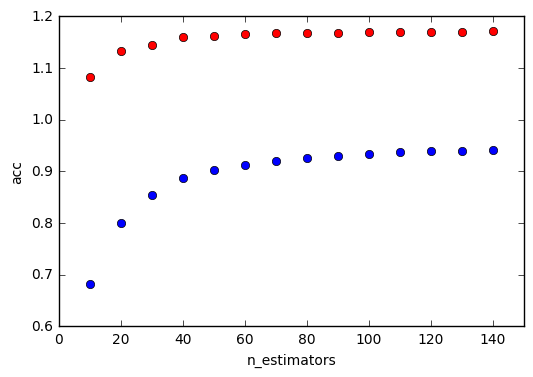

In [39]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.9, 0.9, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.16663317816
Count of estimators: 20, accuracy: 1.18729582109
Count of estimators: 30, accuracy: 1.19034674695
Count of estimators: 40, accuracy: 1.19024177955
Count of estimators: 50, accuracy: 1.18965316542
Count of estimators: 60, accuracy: 1.19021693407
Count of estimators: 70, accuracy: 1.18773486785
Count of estimators: 80, accuracy: 1.18672116121
Count of estimators: 90, accuracy: 1.18731124445
Count of estimators: 100, accuracy: 1.1868946463
Count of estimators: 110, accuracy: 1.18577304682
Count of estimators: 120, accuracy: 1.18572512785
Count of estimators: 130, accuracy: 1.18563042307
Count of estimators: 140, accuracy: 1.18484796258
CPU times: user 9min 27s, sys: 10.4 s, total: 9min 37s
Wall time: 2min 3s


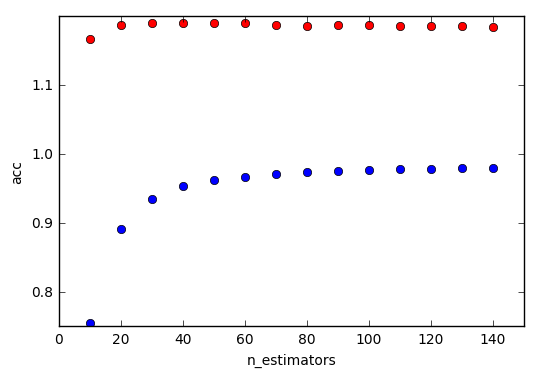

In [40]:
n_est = range(10, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 0.935613812301
Count of estimators: 20, accuracy: 0.984874719669
Count of estimators: 30, accuracy: 1.01058134742
Count of estimators: 40, accuracy: 1.02047745375
Count of estimators: 50, accuracy: 1.03769603514
Count of estimators: 60, accuracy: 1.0417916613
Count of estimators: 70, accuracy: 1.0464839165
Count of estimators: 80, accuracy: 1.0520644733
Count of estimators: 90, accuracy: 1.05417616405
Count of estimators: 100, accuracy: 1.05824511029
Count of estimators: 110, accuracy: 1.06241073089
Count of estimators: 120, accuracy: 1.06278250213
Count of estimators: 130, accuracy: 1.06369863375
Count of estimators: 140, accuracy: 1.06455165276
CPU times: user 7h 2min 40s, sys: 2min 4s, total: 7h 4min 45s
Wall time: 1h 23min 48s


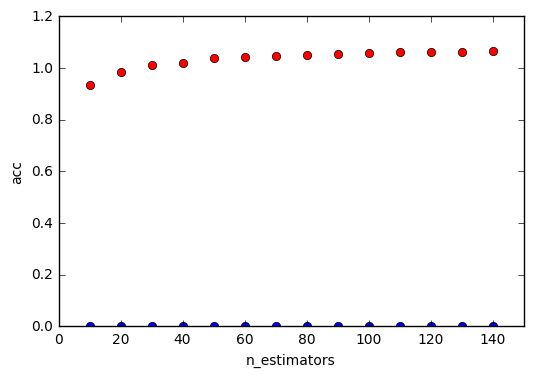

In [42]:
n_est = range(10, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

### Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.23769299312
Count of estimators: 20, accuracy: 1.23221363395
Count of estimators: 30, accuracy: 1.22520704128
Count of estimators: 40, accuracy: 1.22264353343
Count of estimators: 50, accuracy: 1.22126849828
Count of estimators: 60, accuracy: 1.2186660362
Count of estimators: 70, accuracy: 1.21685503498
Count of estimators: 80, accuracy: 1.21454507849
Count of estimators: 90, accuracy: 1.21364591048
Count of estimators: 100, accuracy: 1.21297652818
Count of estimators: 110, accuracy: 1.21203754292
Count of estimators: 120, accuracy: 1.21245308023
Count of estimators: 130, accuracy: 1.21355261323
Count of estimators: 140, accuracy: 1.21263777128
CPU times: user 31min 12s, sys: 17.5 s, total: 31min 29s
Wall time: 33min 8s


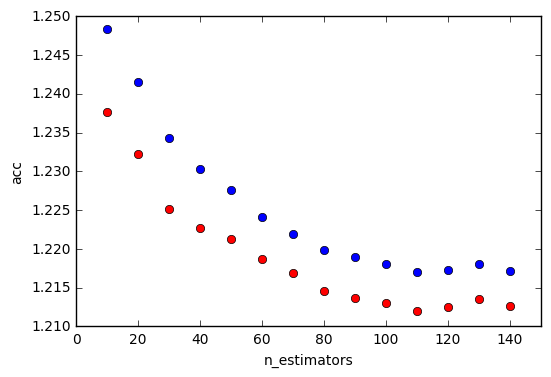

In [41]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

## Другие модели и генерация дополнительных признаков (2 балла)

* На основании сделанных выводов, предложите другой вариант алгоритма ML, который должен показать лучший результат
* Направляния:
    -- использовать принципиально другое семейство алгоритмов (NN, GB+kNN, LinearRegression, композиция Baggin и GBDT)
    -- исключить бесполезные фичи из обучающей выборки (полезность фич проанализировать с помощью RF);
    -- исключить фичи, в которых есть NaN; сделать восстановление NaN более интеллектуально;
    -- преобразовать катеориальные признаки так, чтобы получились числовые.

### Вывод

## Отправка результатов в контест на Kaggle (оценивается по результатам в Leaderboard)

In [43]:
test = pd.read_csv('./data/test.csv', sep=';',decimal= '.', index_col='ID')

In [44]:
# Предобработка тестовой выборки (добавляем\удаляем признаки, предобработка NaN и пр.)
test_data = get_binarized_data(test, Categorical_columns)

In [45]:
# Все отсутствующие в тестовой выборке столбцы полагаем 0
add_columns = bin_data.columns[1:].difference(test_data.columns)
test_data = pd.merge(test_data, bin_data.ix[test_data.index][add_columns], how='inner', left_index=True, right_index=True)
test_data[add_columns]=0

# Оставляем только столбцы обучающей выборки (целевая переменная в обучающей выборке отсутствует)
test_data = test_data[bin_data.columns[1:]]

In [46]:
test_data.fillna(-10, inplace=True)

In [47]:
# Обучающая выборка
trainX, _, trainY, _ = split_train_test(df = bin_data, test_size=0,  y_column_name='DEMAND')

In [48]:
# Обучаем финальный алгоритм
final_regressor = ExtraTreesRegressor(n_estimators=1)
final_regressor.fit(trainX, trainY)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [49]:
# Предсказание интенсивности
test_predict = final_regressor.predict(np.asarray(test_data))

In [50]:
# Сохраняем в csv-файл
test['DEMAND'] = test_predict
test[['DEMAND']].to_csv('./result/submission_gbdt_2.csv', sep = ',', index = True)